# Deep Learning - CIFAR Image Set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

### Import CIFAR data

In [ ]:
# Import CIFAR data
from tensorflow.keras.datasets import cifar10
(_,_), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Color images

In [ ]:
# Split train test using test set from above (10000 samples)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_test, y_test, stratify = y_test,
                                                test_size = 0.2, 
                                                shuffle = True,
                                                random_state = 1)

# Split train data to train and validation data
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, stratify = ytrain,
                                              test_size = 0.25,
                                              shuffle = True,
                                              random_state = 1)

print("Xtrain:{}, Xtest:{}, ytrain:{}, ytest:{}, Xval:{}, yval:{}"
.format(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape, Xval.shape, yval.shape))

Xtrain:(6000, 32, 32, 3), Xtest:(2000, 32, 32, 3), ytrain:(6000, 1), ytest:(2000, 1), Xval:(2000, 32, 32, 3), yval:(2000, 1)


In [ ]:
# check the classes
np.unique(ytrain)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

[2915 2254 4079 1725 3046 5520 2121 1032  740 1982 2459 2672 2718 3792
 4300 3185 5557 4071 3152 1068]


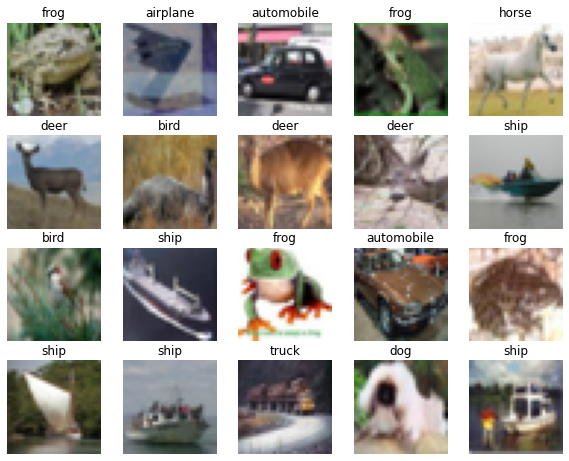

In [ ]:
# View images
np.random.seed(5)
plt.figure(figsize=(10,10))
rand_num = np.random.randint(low = 0, high = Xtrain.shape[0], size = 20)
print(rand_num)
for index, num in enumerate(rand_num):
  plt.subplot(5,5,index+1).set_title(labels[ytrain[num][0]])
  plt.imshow(Xtrain[num])
  plt.axis("off")
plt.show()

### Gray scale images

In [ ]:
# Convert everything to gray scale
Xtrain_gray = np.array(tf.image.rgb_to_grayscale(Xtrain))
Xval_gray = np.array(tf.image.rgb_to_grayscale(Xval))
Xtest_gray = np.array(tf.image.rgb_to_grayscale(Xtest))

In [ ]:
Xtrain_gray.shape

(6000, 32, 32, 1)

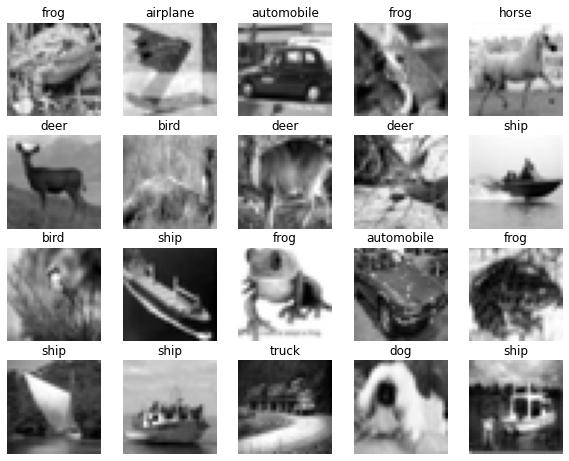

In [ ]:
# View image
plt.figure(figsize = (10,10))
for index, num in enumerate(rand_num):
  plt.subplot(5,5,index+1).set_title(labels[ytrain[num][0]])
  plt.imshow(Xtrain_gray[num].reshape(32,32), cmap = plt.cm.gray)
  plt.axis('off')
plt.show()

### Normalizing color data
- Flatten data then normalize
- Reshape the data back original shape for CNN
- Will compare the performance between normalized and non-normalized data 

In [ ]:
scale = StandardScaler()

In [ ]:
Xtrain_s = scale.fit_transform(Xtrain.reshape(Xtrain.shape[0],-1))
Xval_s = scale.transform(Xval.reshape(Xval.shape[0],-1))
Xtest_s = scale.transform(Xtest.reshape(Xtest.shape[0],-1))

In [ ]:
Xtrain_s.shape

(6000, 3072)

In [ ]:
# Reshape the data
df_list = [Xtrain_s, Xval_s, Xtest_s]
df_list = [x.reshape(x.shape[0],32,32,3) for x in df_list]
Xtrain_s, Xval_s, Xtest_s = [df_list[i] for i in range(len(df_list))]

In [ ]:
Xtest_s.shape

(2000, 32, 32, 3)

### Normalize grayscale data
- Flatten data then normalize
- Reshape the data back original shape for CNN
- Will compare the performance between normalized and non-normalized data 

In [ ]:
Xtrain_gs = scale.fit_transform(Xtrain_gray.reshape(Xtrain_gray.shape[0],-1))
Xval_gs = scale.transform(Xval_gray.reshape(Xval_gray.shape[0],-1))
Xtest_gs = scale.transform(Xtest_gray.reshape(Xtest_gray.shape[0],-1))

In [ ]:
Xtrain_gs.shape

(6000, 1024)

In [ ]:
# Reshape the data
df_list_g = [Xtrain_gs, Xval_gs, Xtest_gs]
df_list_g = [x.reshape(x.shape[0], 32,32,1) for x in df_list_g]
Xtrain_gs, Xval_gs, Xtest_gs = [df_list_g[i] for i in range(len(df_list_g))]

In [ ]:
Xtrain_gs.shape

(6000, 32, 32, 1)

### Recode labels

In [ ]:
# Convert to category
print("Prior to conversion:", ytrain[0])
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
yval = to_categorical(yval)
print("Post converstion:", ytrain[0])

Prior to conversion: [7]
Post converstion: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### Build Model Functions

In [ ]:
# Create Model
def create_model(seed = 100, output_layer, compile_mod, convo_layer = None, 
                 pool_layer = None, nn_layer = None):
  tf.random.set_seed(int(seed))

  # Initiate model
  model = Sequential()

  # CNN - Convo and Pool Layers
  if convo_layer is not None:
    for i in range(convo_layer['layer']):
      # Create first Convo layer
      if i == 0:
        model.add(Conv2D(filters = convo_layer['filter'][i],
                         kernel_size = convo_layer['window'][i],
                         strides = convo_layer['strides'],
                         activation = convo_layer['activation'][i],
                         padding = 'same',
                         input_shape = convo_layer['input_shape']
                         ))
      # Subsequent Convo layer
      else:
        model.add(Conv2D(filters = convo_layer['filter'][i],
                         kernel_size = convo_layer['window'][i],
                         strides = convo_layer['strides'],
                         activation = convo_layer['activation'][i],
                         padding = 'same'
                         ))
      # If Pool layer create Pool layer
      # else, create next Convo layer
      if pool_layer is not None:
          model.add(MaxPooling2D(pool_size = pool_layer['window'],
                                strides = pool_layer['strides'],
                                padding = 'valid'
                                ))
      else:
          continue
  
    # Flatten the model to be fed to NN or output layer
    model.add(Flatten())

  # Add hidden layers to CNN or just create NN only
  if nn_layer is not None:
    for i in range(nn_layer['layer']):
      # Create first layer of NN
      if i == 0 and (convo_layer is None):
        model.add(Dense(units = nn_layer['neuron'][i],
                      activation = nn_layer['activation'][i],
                      input_shape = (nn_layer['input_shape'], ) 
                      ))
      
      # Create subsequent layers of NN
      elif (i == 0 and (convo_layer is not None)) or (i>0 and (convo_layer is None)):
        # l1 regularization
        if nn_layer['l1'][i] != 0: 
          model.add(Dense(units = nn_layer['neuron'][i],
                      activation = nn_layer['activation'][i],
                      kernel_regularizer = keras.regularizers.l1(nn_layer['l1'][i])
                      ))
        
        # l2 regularization
        elif nn_layer['l2'][i] != 0:
          model.add(Dense(units = nn_layer['neuron'][i],
                      activation = nn_layer['activation'][i],
                      kernel_regularizer = keras.regularizers.l2(nn_layer['l2'][i])
                      ))
          
        # No regularization
        else:
          model.add(Dense(units = nn_layer['neuron'][i],
                      activation = nn_layer['activation'][i]
                      ))
        
        # Drop out layer
        if nn_layer['dropout'][i] != 0:
          model.add(Dropout(rate = nn_layer['dropout'][i]
                          )) 
    
  # Output layer
  model.add(Dense(units = output_layer['neuron'],
                  activation = output_layer['activation']
                  ))
  
  # Compile model
  model.compile(optimizer = compile_mod['optimizer'],
                loss = compile_mod['loss'],
                metrics = compile_mod['metrics'])
  
  # Print out the summary
  print(model.summary())

  return model

In [ ]:
# Fit Model
def fit_model(model, xtrain, ytrain, xval, yval, epoch, batchsize, earlystop = False):
  # Fit model with or without EarlyStopping
  if earlystop == True:
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
    history = model.fit(xtrain, ytrain, epochs = epoch, batch_size = batchsize,
                      validation_data = (xval,yval),
                      callbacks = [early_stop],
                      verbose = 0) 
  
  else:
    history = model.fit(xtrain, ytrain, epochs=epoch, batch_size = batchsize,
                      validation_data = (xval, yval),
                      verbose = 0)
  
  # Get the values of metrics
  metric_names= list(history.history.keys())
  values = [list(history.history.values())[i][-1] 
            for i in range(len(list(history.history.values())))]
  
  dict_result = dict(zip(metric_names, values))

  return history, dict_result

In [ ]:
# Plot History Results
def plot_results(history):
  # List of all metrics
  metrics = list(history.history.keys()) 
  # Lists of metrics of train and validation
  train_metrics = metrics[0:int(len(metrics)/2)]
  val_metrics = metrics[int(len(metrics)/2):]

  fig, ax = plt.subplots(nrows = len(train_metrics), figsize =(15,10))
  for i in range(len(train_metrics)):
    ax[i].set_title(train_metrics[i].upper())
    ax[i].plot(history.history[train_metrics[i]], label = "Train")
    ax[i].plot(history.history[val_metrics[i]], label = 'Val')
    ax[i].set_xlabel('Epochs')
    ax[i].legend()
  
  plt.subplots_adjust(hspace=1)

### Compares Models of Different Types of Images

In [ ]:
# Create dictionaries for pool, ouput and compile input of create_model()
pool = {'window': 2,
        'strides': 2}

output = {'neuron': 10,
          'activation': 'softmax'}

compile = {'optimizer': 'adam',
           'loss':'categorical_crossentropy',
           'metrics': ['accuracy','Recall','Precision']}

In [ ]:
# Neural Net layer
nn1 = {'layer': 1, 
      'neuron': [40],
      'input_shape':0,
      'activation': ['relu'],
      'dropout': [0],
      'l1': [0],
      'l2':[0]}

In [ ]:
# Create models for different types of images 
train_list = [Xtrain, Xtrain_s, Xtrain_gray, Xtrain_gs]
val_list = [Xval, Xval_s, Xval_gray, Xval_gs]
hist_list = []
dict_list = []
for i in range(len(train_list)):
  input_shape = train_list[i].shape[1:]
  conv = {'layer': 2,
        'filter': [16,8],
        'window': [3]*2,
        'strides': 1,
        'activation': ['relu']*2,
        'input_shape': input_shape}
  model = create_model(output_layer=output, compile_mod=compile,
                       convo_layer=conv,pool_layer=pool, nn_layer=None)
  history, dict_results = fit_model(model, train_list[i], ytrain, val_list[i],
                                    yval, epoch = 100, batchsize = 500, 
                                    earlystop = False)
  hist_list.append(history)
  dict_list.append(dict_results)

''' Calculate #parameters for each layer
Input layer: 1 filter (gray), 3 filters (color)
#_parameter = (width_filter * ht_filter * #_previous_layer_filter + 1) * #_filter
Color images:
conv1 = (3*3*3 + 1)*16 = 448
conv2 = (3*3*16 + 1)*8 = 1160
Gray images:
conv1 = (3*3*1 + 1)*16 = 160
conv2 = (3*3*16 + 1)*8 = 1160
'''

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 6,738
Trainable params: 6,738
Non-trainable params: 0
______________________________________________________

' Calculate #parameters for each layer\nInput layer: 1 filter (gray), 3 filters (color)\n#_parameter = (width_filter * ht_filter * #_previous_layer_filter + 1) * #_filter\nColor images:\nconv1 = (3*3*3 + 1)*16 = 448\nconv2 = (3*3*16 + 1)*8 = 1160\nGray images:\nconv1 = (3*3*1 + 1)*16 = 160\nconv2 = (3*3*16 + 1)*8 = 1160\n'

In [ ]:
df_result = pd.DataFrame.from_dict(dict_list)
df1 =pd.DataFrame.from_dict({'Type':['color', 'color_norm', 'gray', 'gray_norm']})
res_table = pd.concat([df1,df_result], axis=1)
res_table

,Type,loss,accuracy,recall,precision,val_loss,val_accuracy,val_recall,val_precision
0,color,1.607433,0.412833,0.160667,0.748447,2.177955,0.3095,0.0895,0.380851
1,color_norm,0.836795,0.711833,0.595667,0.826549,1.402895,0.5395,0.4450,0.630758
2,gray,1.380441,0.516667,0.295500,0.706656,2.003603,0.3705,0.1975,0.462529
3,gray_norm,1.041404,0.642500,0.470667,0.794821,1.413724,0.5200,0.3835,0.647804


The results show that normalized data perform better than non-normalized. Between the normalized colored and grayed images, the colored ones have better recall but lower precision. In this example, we focus more on the accuracy and recall. However, in examples such as medical diagnoses, we should emphasize more on recall and precision and try to balance both or pick the one that is more important. 

### Optimize Models - Gray Images